# Local Volatility Model
------------------
> **Idriss Afra**

This project aims to strip the Equity Local Volatility surface and implement the associated PDE pricing method.

## Model Description
The Local Volatility model assumes the following SDE under the risk-neutral measure :   

$$
dS_t = (r_t - q_t) \times S_t \times dt + \sigma(t, S_t) \times S_t \times dW_t
$$

Where $S_t$ is the stock or index price, $r_t$ is the deterministic instantaneous forward interest rate, $q_t$ is the deterministic instantaneous forward dividend yield, $\sigma(t, S_t)$ is the deterministic local volatility function, and $W_t$ is a standard brownian motion.

The price of a European call option $C(T, K)$ satisfies the following forward Kolmogorov PDE:    

$$
\frac{dC}{dT} + \left(r_T - q_T\right)K\frac{dC}{dK}-\frac{1}{2}\sigma^2(T, K)K^2\frac{d^2C}{dK^2} + q_TC = 0
$$

From this, we derive the Dupire equation:     
$$
\sigma^2(T, K) = 2\times\frac{\frac{dC}{dT} + \left(r_T - q_T\right)K\frac{dC}{dK} + q_TC}{K^2\frac{d^2C}{dK^2}}
$$

By applying the chain rule, we obtain the stripping formula used to calibrate the local volatility surface from the implied total variance surface:
$$
\sigma^2(t=T, S_t=K) = \frac{\frac{d\omega}{dT}}{1 - \frac{k}{\omega} \frac{d\omega}{dk} + \frac{1}{2} \frac{d^{2}\omega}{dk^{2}} + \frac{1}{4} \left( -\frac{1}{4} -\frac{1}{\omega} + \frac{k^{2}}{\omega^{2}} \right) \left( \frac{d\omega}{dk} \right)^{2} }
$$
Where $\omega(T, k)$ is the implied total variance, expressed as a function of time to maturity $T$ and log-moneyness $k=log\left(\frac{K}{F_T}\right)$, with $F_T$ being the forward price at time $T$.

Unlike the Black-Scholes model, which assumes constant volatility, the Local Volatility model allows volatility to vary with both time and the underlying asset’s price. This leads to a more realistic framework and enables enhanced replication of observed market option prices via the above stripping formula.
<br>However, the model presents some limitations. In particular, the stripped local volatility surface tends to flatten for long maturities, largely due to the illiquidity of long-dated options. As a result, the Local Volatility model is less suitable for pricing long-term or forward-starting derivatives. Additionally, the Greeks (i.e., sensitivity measures) derived from the Local Volatility model have been shown to be less accurate, reducing the model’s effectiveness in risk management applications.

### The Implied Total Variance

To extract the Local Volatility surface, we first need to compute the partial derivatives of the implied total variance $\omega(T, k)$ with respect to maturity and log-moneyness. This requires constructing a continuous, smooth, and arbitrage-free total variance function from the market listed options.
<br>In this project, we adopt the Stochastic Volatility Inspired (SVI) parameterization, a widely-used and flexible model that enables a stable fit to implied volatility skews across maturities. Additionally, the SVI approach facilitates the correction of potential Butterfly and Calendar arbitrages, which, if left unaddressed, can result in irregularities such as spikes or negative values in the stripped local volatility surface.

In [19]:
# Required Libraries
import numpy as np
from matplotlib import cm
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,8)

# SVI Model Class
class SVIModel:
    """
    SVI model.
    """
    def __init__(self, a, b, rho, m, sigma):
        """
        The parameters are given as dictionnaries, with the provided SVI expiries as keys. 
        """
        # Sanity checks
        if not (isinstance(a, dict) and isinstance(b, dict) and isinstance(rho, dict) 
                and isinstance(m, dict) and isinstance(sigma, dict)):
            raise TypeError("All parameters must be provided as dictionaries.")
        if not (set(a.keys()) == set(b.keys()) == set(rho.keys()) == set(m.keys()) == set(sigma.keys())):
            raise ValueError("All parameter dictionaries must have the same keys.")
        # Store SVI expiries and parameters
        self.expiries = list(a.keys())
        self.a = a
        self.b = b
        self.rho = rho
        self.m = m
        self.sigma = sigma
        
    def svi_v2T(self, T, k) :
        """
        V2T formula under the SVI model.
        The log-moneyness k can be a scalar or an array.
        """
        if T not in self.expiries : 
            raise ValueError(f"The given expiry {T} is not part of the provided SVI expiries.")
        return self.a[T] + self.b[T] * (self.rho[T] * (k - self.m[T]) + np.sqrt((k - self.m[T])**2 + self.sigma[T] **2))

    def svi_vol(self, T, k) :
        """
        Vol formula under the SVI model.
        The log-moneyness k can be a scalar or an array.
        """
        return np.sqrt(self.svi_v2T(T, k) / T)

    def get_v2T(self, T, k, min_k=np.log(0.3), max_k=np.log(1.7)) :
        """
        V2T formula under the SVI model.
        Log-moneyness k : SVI formula within [min_k, max_k] & Flat extrapolation.
        Expiry T : PCHIP interpolation in total variance & Flat right time extrapolation.
        For T < T0 (Left time extrapolation), we use w(T,k) = (T/T0) * w(T0,k) so that w(0,k)=0.
        """
        # Sanity check
        if min_k >= max_k: raise ValueError("min_k must be less than max_k.")
        # Handle non-positive maturities
        if T <= 0.0: return 0.0
        # Clamp k for flat extrapolation in log-moneyness
        k = np.clip(k, min_k, max_k)
        # Get first and last expiry
        T0 = self.expiries[0]
        Tn = self.expiries[-1]
        # Left time extrapolation
        if T < T0:
            w0 = self.svi_v2T(T0, k)
            return (T / T0) * w0
        # Flat right time extrapolation
        if (T >= Tn): return self.svi_v2T(Tn, k)
        # PCHIP interpolation between SVI expiries
        v2T_k = np.array([self.svi_v2T(exp, k) for exp in self.expiries], dtype=float)
        return PchipInterpolator(self.expiries, v2T_k, extrapolate=False)(T)
        
    def plot_svi_surface(self, total_var=False, min_k=np.log(0.6), max_k=np.log(1.4), min_T=0.5, n_interv=81) :
        """
        SVI surface plotter.
        """
        # Sanity checks
        if not isinstance(n_interv, int) or n_interv < 10:
            raise ValueError("n_interv must be an integer >= 10.")
        if min_k >= max_k:
            raise ValueError("min_k must be less than max_k.")
        if min_T <= 0 or min_T >= list(self.expiries)[-1]:
            raise ValueError("min_T must be positive falling before the maximum expiry.")
        # Surface data computation
        K = np.linspace(min_k, max_k, n_interv, endpoint=True)
        T = np.linspace(min_T, self.expiries[-1], n_interv, endpoint=True)
        K, T = np.meshgrid(K, T)
        vols = np.zeros(shape=K.shape)
        for t in range(vols.shape[0]):
            for k in range(vols.shape[1]):
                vols[t, k] = self.get_v2T(T[t][k], K[t][k]) if total_var else np.sqrt(self.get_v2T(T[t][k], K[t][k]) / T[t][k])
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        ax.set_xlabel("Log-moneyness (k)", labelpad=10)
        ax.set_ylabel("Time to expiry (T)", labelpad=10)
        # Workaround to ensure the display of the zlabel 
        ax.set_zlabel("")
        ax.text2D(
            1.05, 0.52, "Implied volatility (σ)",
            transform=ax.transAxes,
            rotation=90,
            va="center", ha="left",
            fontsize=12,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.8)
        )
        ax.set_title("Implied SVI Volatility Surface" if not total_var else "Implied SVI Total Variance Surface", pad=20)
        fig.subplots_adjust(left=0.02, right=0.88, bottom=0.05, top=0.92)
        # Show the plot
        plt.show()

### The Implied Forward Curve

The implied forward prices of the underlying asset are required to compute both the log-moneyness values and the drift term in the PDE.

In [20]:
# Required Libraries
from scipy.interpolate import interp1d

class ForwardCurve:
    """
    The implied forward curve class.
    """
    def __init__(self, S0, zc_rate, implied_repos_and_divs):
        """
        Init method.
        """
        # Sanity checks
        if not isinstance(S0, (int, float)) or S0 <= 0:
            raise ValueError("S0 must be a positive number.")
        if not callable(zc_rate):
            raise TypeError("zc_rate must be a callable function.")
        if not isinstance(implied_repos_and_divs, dict):
            raise TypeError("implied_repos_and_divs must be a dictionary.")
        # Store attributes and set implied_repos_and_divs
        self.S0 = S0
        self.zc_rate = zc_rate
        self.listed_expiries = list(implied_repos_and_divs.keys())
        self.implied_repos_and_divs = implied_repos_and_divs
        self.set_repo_div_func()
    
    def set_repo_div_func(self):
        """
        Setter method of implied repo plus dividend yields, assuming they are piecewise constant between the market expiries.
        """
        # Dividend Yield function : Piece-Wise Interpolation & Flat Extrapolation
        self.repo_div_func = interp1d([0] + self.listed_expiries, list(self.implied_repos_and_divs.values()) + \
                            [list(self.implied_repos_and_divs.values())[-1]], kind='previous', fill_value="extrapolate")

    def calc_forward(self, exp):
        """
        Computes the forward up to exp, given the repo_div_func attribute.
        """
        if exp < 0: raise ValueError("Expiry must be non-negative.")
        if exp == 0: return self.S0
        expiries = [0] + self.listed_expiries + [exp]
        expiries = sorted(list(set(expiries)))
        expiries = expiries[:expiries.index(exp) + 1]
        cumul = 0
        for i in range(len(expiries) - 1):
            cumul += (expiries[i + 1] - expiries[i]) * self.repo_div_func(expiries[i])
        return self.S0 * np.exp(self.zc_rate(exp) * exp - cumul)

### The Stripping Algorithm

In [21]:
# For printing purposes
import warnings
warnings.filterwarnings("ignore")

# Local Volatility Surface Class
class LocalVolatilitySurface :
    """
    Local Volatility model.
    """
    def __init__(self, forward_curve, svi_model, min_moneyness=0.3, max_moneyness=1.7, lv_floor=0.01, lv_cap=3.0):
        """
        Init method :
        - The implied total variance is computed using the svi_model.
        - Local Volatility is stripped within the range defined by min_moneyness and max_moneyness, and up to 
          the last expiry of the SVI model. Outside these bounds, the surface is held flat.
        """
        # Sanity checks
        if forward_curve is None or not isinstance(forward_curve, ForwardCurve):
            raise ValueError("forward_curve must be an object of the ForwardCurve class.")
        if svi_model is None or not isinstance(svi_model, SVIModel):
            raise ValueError("svi_model must be an object of the SVIModel class.")
        if min_moneyness >= max_moneyness:
            raise ValueError("min_moneyness must be less than max_moneyness.")
        if lv_floor >= lv_cap:
            raise ValueError("lv_floor must be less than lv_cap.")
        # lv floor safe guard to avoid numerical issues
        lv_floor = max(lv_floor, 1e-4)
        # Store attributes
        self.forward_price = forward_curve.calc_forward
        self.implied_v2T = svi_model.get_v2T
        self.min_moneyness = min_moneyness
        self.max_moneyness = max_moneyness 
        self.expiries = np.array(svi_model.expiries, dtype=float)
        self.min_exp = 1e-8 # pricing date
        self.max_exp = svi_model.expiries[-1]
        self.lv_floor = lv_floor
        self.lv_cap = lv_cap
        
    def get_local_vol(self, t, S, debug=False):
        """
        Loval Volatility getter : 
        - LV(t, S), floored by lv_floor and capped by lv_cap in case of stripping anomalies.
        """
        # Clamp t and S within the defined bounds
        t = min(self.max_exp, max(self.min_exp, t))
        fwd = self.forward_price(t)
        S = min(self.max_moneyness * fwd, max(self.min_moneyness * fwd, S))
        # Spot price S to log-moneyness k
        k = np.log(S / fwd)
        # Compute local vol
        lv = self._dupire_func(t, k)
        if debug:
            # Print debug info to detect arbitrages and anomalies
            if lv <= self.lv_floor : print(f"Local vol floored by {self.lv_floor} at : ({t}, {S}), due to implied arbitrages.")
            if lv >= self.lv_cap : print(f"Local vol capped by {self.lv_cap} at : ({t}, {S}), due to implied arbitrages.")
        return min(max(lv, self.lv_floor), self.lv_cap)
        
    def _dv2T_dT(self, t, k, eps_t):
        """
        Partial derivative of v2T(t,k) with respect to t using finite differences:
        => Centeral when possible, forward or backward near boundaries.
        eps_t : bump size in time direction
        """
        t_min = self.min_exp
        t_max = self.max_exp
        eps_t = max(eps_t, 1e-6)
        if t - eps_t <= t_min:
            # Forward finite differences near the lower time boundary
            t0 = max(t_min, t)
            return (self.implied_v2T(t0 + eps_t, k) - self.implied_v2T(t0, k)) / eps_t
        elif t + eps_t >= t_max:
            # Backward finite differences near the upper time boundary
            t1 = min(t_max, t)
            return (self.implied_v2T(t1, k) - self.implied_v2T(t1 - eps_t, k)) / eps_t
        else:
            # Centeral finite differences
            return (self.implied_v2T(t + eps_t, k) - self.implied_v2T(t - eps_t, k)) / (2.0 * eps_t)

    def _dv2T_dk(self, t, k, eps_k):
        """
        Partial derivative of v2T(t,k) with respect to k using finite differences:
        => Centeral when possible, forward or backward near boundaries.
        eps_k : bump size in k direction
        """
        k_min = np.log(self.min_moneyness)
        k_max = np.log(self.max_moneyness)
        if k - eps_k <= k_min:
            # Forward finite differences near the lower k boundary
            k = max(k_min, k)
            return (self.implied_v2T(t, k + eps_k) - self.implied_v2T(t, k)) / eps_k
        elif k + eps_k >= k_max :
            # Backward finite differences near the upper k boundary
            k = min(k_max, k)
            return (self.implied_v2T(t, k) - self.implied_v2T(t, k - eps_k)) / eps_k
        else:
            # Centeral finite differences
            return (self.implied_v2T(t, k + eps_k) - self.implied_v2T(t, k - eps_k)) / (2 * eps_k)

    def _d2v2T_dk2(self, t, k, eps_k):
        """
        Second partial derivative of v2T(t,k) with respect to k using centeral finite differences:
        eps_k : bump size in k direction
        """
        k_min = np.log(self.min_moneyness)
        k_max = np.log(self.max_moneyness)
        k = min(k_max - eps_k, max(k_min + eps_k, k))
        return (self.implied_v2T(t, k + eps_k) + self.implied_v2T(t, k - eps_k) - 2 * self.implied_v2T(t, k)) / (eps_k**2)

    def _dupire_func(self, t, k):
        """
        Dupire formula for local volatility, with respect to time and log-moneyness.
        """
        w = self.implied_v2T(t, k)
        # Avoid non-negative total variances
        w = max(w, 1e-12) 
        invw = 1.0 / w
        # Compute partial derivatives
        eps_t = max(1e-3, 1e-2 * t)
        eps_k = 2e-4
        dw_dT = self._dv2T_dT(t, k, eps_t)
        dw_dT = max(dw_dT, 1e-12)
        dw_dk = self._dv2T_dk(t, k, eps_k)
        d2w_dk2 = self._d2v2T_dk2(t, k, eps_k)
        num = dw_dT
        den = 1.0 - k * invw * dw_dk + 0.5 * d2w_dk2 + 0.25 * (-0.25 - invw + invw**2 * k**2) * (dw_dk**2)
        # Avoid division by zero or negative denominators
        den = max(den, 1e-12)
        lv2 = num / den
        return np.sqrt(lv2)

    def plot_lv_surface(self, min_k=np.log(0.6), max_k=np.log(1.4), min_T=0.5, n_interv=81):
        """
        LV surface plotter.
        """
        # Sanity checks
        if not isinstance(n_interv, int) or n_interv < 10:
            raise ValueError("n_interv must be an integer >= 10.")
        if min_k >= max_k:
            raise ValueError("min_k must be less than max_k.")
        if min_T <= 0:
            raise ValueError("min_T must be positive.")
        # Surface data computation
        K = np.linspace(min_k, max_k, n_interv, endpoint=True)
        T = np.linspace(min_T, self.max_exp, n_interv, endpoint=True)
        K, T = np.meshgrid(K, T)
        S = np.zeros(shape=K.shape)
        vols = np.zeros(shape=K.shape)
        for t in range(vols.shape[0]):
            for k in range(vols.shape[1]):
                S[t, k] = np.exp(K[t][k]) * self.forward_price(T[t][k])
                vols[t, k] = self.get_local_vol(T[t][k], S[t, k])
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(S, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        ax.set_xlabel("Underlying price (S)", labelpad=10)
        ax.set_ylabel("Time to expiry (T)", labelpad=10)
        # Workaround to ensure the display of the zlabel 
        ax.set_zlabel("")
        ax.text2D(
            1.05, 0.52, "Local volatility (σ)",
            transform=ax.transAxes,
            rotation=90,
            va="center", ha="left",
            fontsize=12,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.8)
        )
        ax.set_title("Local Volatility Surface", pad=20)
        fig.subplots_adjust(left=0.02, right=0.88, bottom=0.05, top=0.92)
        # Show the plot
        plt.show()

### PDE Pricing Method
We use a Crank–Nicolson implicit finite-difference scheme, as detailed in the following project: [Hull & White One Factor Model](https://github.com/Idriss-Afra/Hull-White-One-Factor-Model/blob/main/Hull-White%201F%20Model.ipynb).

In [22]:
# Required Libraries
import math
from scipy.linalg import solve_banded

class LocalVolatilityPDEPricer :
    """
    European Option Local Volatility PDE Pricer.
    PDE:
        ∂V/∂t + 0.5 * σ(t, S)² * S² * V_SS + (r - q) * S * V_S - r * V  = 0
    Inputs:
        zc_rate       : Zero-Coupon rate function T -> ZCRate(T)
        forward_curve : instance of ForwardCurve
        lv_model      : instance of LocalVolatilitySurface
        nx            : Number of space nodes
        dt            : target max time step
        s_pad         : used for padding around [min_moneyness, max_moneyness] when building S-grid
    """
    def __init__(self, zc_rate, forward_curve, lv_model, nx=501, dt=0.001, s_pad=0.25):
        """
        Init method.
        """
        # Sanity checks
        if not callable(zc_rate):
            raise TypeError("zc_rate must be a callable function.")
        if forward_curve is None or not isinstance(forward_curve, ForwardCurve):
            raise ValueError("forward_curve must be an object of the ForwardCurve class.")
        if lv_model is None or not isinstance(lv_model, LocalVolatilitySurface):
            raise ValueError("lv_model must be an object of the LocalVolatilitySurface class.")
        if nx < 51:
            raise ValueError("nx must be an integer >= 51.")
        if dt <= 0:
            raise ValueError("dt must be a positive number.")
        if s_pad < 0:
            raise ValueError("s_pad must be a non-negative number.")
        # Store and initialize attributes
        self.zc_rate = zc_rate
        self.forward_price = forward_curve.calc_forward
        self.lv_model = lv_model
        self.nx = int(nx)
        if self.nx % 2 == 0: self.nx += 1 # Ensure odd number of space nodes to center S0
        self.dt = dt
        self.s_pad = s_pad
        self.T = None
        self.t = None
        self.S = None
        self.dS = None
        self.lv_grid = None

    def _build_time_grid(self, T):
        """
        PDE time steps from 0 to T, min 50 steps.
        """
        # Default minimum time step
        dt_min = T / 50.0
        dt = min(self.dt, dt_min)
        pde_t = np.arange(0.0, T + dt, dt)
        t = np.unique(np.sort(pde_t))
        return t

    def _build_space_grid(self, T):
        """
        Builds S grid using LV moneyness bounds and the padding attribute.
        """
        S0  = self.forward_price(0.0)
        F0T = self.forward_price(T)
        S_min = (self.lv_model.min_moneyness * F0T) * (1.0 - self.s_pad)
        S_max = (self.lv_model.max_moneyness * F0T) * (1.0 + self.s_pad)
        # Ensure S grid is symmetric around S0
        W = max(S0 - S_min, S_max - S0)
        S_left  = max(1e-12, S0 - W)
        S_right = S0 + W
        S = np.linspace(S_left, S_right, self.nx, endpoint=True)
        # Constant space step
        dS = (S[-1] - S[0]) / (self.nx - 1.0)
        return S, dS

    def prepare_grid(self, T, expiries=None, apply_smoothness=True, stride=4):
        """
        Builds time and space grids for a given maturity T:
        - It optionally forces-insert intermediate expiries
        - It constructs local vol grid self.lv_grid
        If apply_smoothness is True, it applies PCHIP interpolation in space to 
        smooth the local vol grid for each time slice, using a stride to speed 
        up the interpolation.
        """
        # Sanity check
        if T <= 0.0: raise ValueError("Maturity T must be positive.")
        # Intermediate expiries
        if expiries is not None:
            expiries = np.array(expiries, dtype=float)
            expiries = expiries[(expiries >= 0.0) & (expiries <= T + 1e-8)]
            if not np.any(np.isclose(T, expiries)):
                expiries = np.append(expiries, T)
        # Last expiry
        self.T = T
        # Time grid
        t = self._build_time_grid(self.T)
        # Insert intermediate expiries into time grid
        if expiries is not None:
            t = np.unique(np.sort(np.concatenate([t, expiries])))
        self.t = t
        # Space grid
        if expiries is None:
            self.S, self.dS = self._build_space_grid(self.T)
        else:
            S0 = self.forward_price(0.0)
            # Determine S_min and S_max over the given expiries
            S_min = np.inf
            S_max = -np.inf
            for Ti in expiries:
                F = self.forward_price(Ti)
                S_min_i = (self.lv_model.min_moneyness * F) * (1.0 - self.s_pad)
                S_max_i = (self.lv_model.max_moneyness * F) * (1.0 + self.s_pad)
                S_min = min(S_min, S_min_i)
                S_max = max(S_max, S_max_i)
            if not np.isfinite(S_min) or not np.isfinite(S_max):
                # Safety guard : Fallback to default space grid
                self.S, self.dS = self._build_space_grid(self.T)
            else:
                # Max width around S0
                W = min(S0 - S_min, S_max - S0)
                S_left  = S0 - W
                S_right = S0 + W
                # Build space grid
                self.S = np.linspace(S_left, S_right, self.nx, endpoint=True)
                self.dS = (self.S[-1] - self.S[0]) / (self.nx - 1.0)
        # Local vol grid
        S = self.S
        nx = len(S)
        nt = len(self.t)
        lv_grid = np.empty((nt, nx), dtype=float)
        if apply_smoothness:
            # Use PCHIP interpolation in space for each time slice
            idx = np.arange(0, nx, stride, dtype=int)
            if idx[-1] != nx - 1: idx = np.append(idx, nx - 1)
            spot_grid = S[idx]
            for it, ti in enumerate(self.t):
                local_vols = np.array([self.lv_model.get_local_vol(ti, s) for s in spot_grid], dtype=float)
                f = PchipInterpolator(spot_grid, local_vols, extrapolate=True)
                lv_grid[it, :] = f(S)
                lv_grid[it, :] = np.clip(lv_grid[it, :], self.lv_model.lv_floor, self.lv_model.lv_cap)
        else:
            # No Local volatility smoothing
            for it, ti in enumerate(self.t):
                lv_grid[it, :] = np.array([self.lv_model.get_local_vol(ti, s) for s in S], dtype=float)
        self.lv_grid = lv_grid

    def vanilla_price(self, T, K, isCall, apply_smoothness=True, theta=0.5):
        """
        European vanilla price by PDE.
        Reuses prepared grid if available and self.T >= T.
        The Crank-Nicolson implicit scheme is used by default (theta=0.5).
        If apply_smoothness is True, the local vol grid is smoothed by PCHIP 
        interpolation in space for each time slice, using a stride to speed 
        up the interpolation.
        """
        # Sanity checks
        if K <= 0.0: raise ValueError("Strike K must be positive.")
        if T < 0.0: raise ValueError("Maturity T must be non-negative.")
        if theta < 0.0 or theta > 1.0: raise ValueError("Theta must be in [0, 1].")
        # At maturity, price is intrinsic value
        if T == 0.0:
            phi = 1.0 if isCall else -1.0
            return max(phi * (self.forward_price(0.0) - K), 0.0)
        # Helpers : discount factors
        def DF_r(t):
            return math.exp(-self.zc_rate(t) * t)
        # Helpers : dividend discount factors
        def DF_q(t):
            return self.forward_price(t) * DF_r(t) / self.forward_price(0)
        DF_r_T = DF_r(T)
        DF_q_T = DF_q(T)
        # Ensure we have a grid that covers T
        grid_ok = (self.T is not None) and (self.t is not None) and (self.S is not None) and (self.T + 1e-8 >= T)
        if not grid_ok:
            # build a new grid just for this T
            self.prepare_grid(T, expiries=None, apply_smoothness=apply_smoothness)
        # Extract relevant time nodes up to T
        t_full = self.t
        idx_t = np.nonzero(t_full <= T + 1e-8)[0]
        t = t_full[idx_t]
        t = np.unique(t)
        # PDE Parameters
        S = self.S
        dS = self.dS
        nx = len(S)
        nt = len(t)
        # Terminal payoff
        phi = 1.0 if isCall else -1.0
        V = np.maximum(phi * (S - K), 0.0)
        # Local vol slice aligned with t nodes
        lv_grid = self.lv_grid[idx_t, :]
        # Backward time-stepping
        for i in range(nt - 2, -1, -1):
            t0 = t[i]
            t1 = t[i + 1]
            dt = t1 - t0
            df_r0, df_r1 = DF_r(t0), DF_r(t1)
            df_q0, df_q1 = DF_q(t0), DF_q(t1)
            # Approximation of forward intanstantaneous rate and dividend yield
            r = -math.log(df_r1 / df_r0) / dt
            q = -math.log(df_q1 / df_q0) / dt
            # Averaged local vol between t0 and t1 for stability (variance averaging)
            sig0 = lv_grid[i, :]
            sig1 = lv_grid[i+1, :] if (i+1) < lv_grid.shape[0] else sig0
            sig = np.sqrt(0.5*(sig0*sig0 + sig1*sig1))
            # PDE Coefficients
            var = (sig * sig) * (S * S) * dt
            mu  = (r - q) * S * dt
            rdt = r * dt
            # Tridiagonal coefficients
            alpha_u = (var + mu * dS) / (2.0 * dS**2)
            alpha_d = (var - mu * dS) / (2.0 * dS**2)
            alpha_c = -var / dS**2
            # Transition coefficients
            p_ur = (1.0 - theta) * alpha_u
            p_dr = (1.0 - theta) * alpha_d
            p_cr = (1.0 - theta) * alpha_c + 1.0 - (1.0 - theta) * rdt
            p_ul = -theta * alpha_u
            p_dl = -theta * alpha_d
            p_cl = -theta * alpha_c + 1.0 + theta * rdt
            # Compute the right member (Intrinsic values at boundaries)
            df_r = DF_r_T / df_r0
            df_q = DF_q_T / df_q0
            if isCall:
                V_left  = 0.0
                V_right = max(S[-1] * df_q - K * df_r, 0.0)
            else:
                V_left  = max(K * df_r - S[0] * df_q, 0.0)
                V_right = 0.0
            right = np.empty(nx, dtype=float)
            p_cl[0], p_ul[0], p_dl[0] = 1.0, 0.0, 0.0
            right[0] = V_left
            p_cl[-1], p_ul[-1], p_dl[-1] = 1.0, 0.0, 0.0
            right[-1] = V_right
            right[1:nx-1] = (p_dr[1:nx-1] * V[0:nx-2] +
                             p_cr[1:nx-1] * V[1:nx-1] +
                             p_ur[1:nx-1] * V[2:nx])
            # Backward step by inverting a tridiagonal matrix : Implicit Scheme
            upper_band = np.insert(p_ul, 0, 0.0)[:-1]
            lower_band = np.append(p_dl[1:nx], 0.0)
            tridiag = np.array([upper_band, p_cl, lower_band])
            V = solve_banded((1, 1), tridiag, right)
        # Final price
        mid_index = (self.nx - 1)//2
        return float(V[mid_index])

---
## Application : CAC40 Listed Index Options

Let's strip the local volatility of the French index CAC40. To achieve this, we use the CAC40 implied forwards and volatilities as of February 12, 2025, derived in the following project : [Equity Implied Forward & Volatility Surface](https://github.com/Idriss-Afra/Equity-Implied-Volatility-Surface/blob/main/Equity%20Implied%20Forward%20%26%20Volatility%20Surface.ipynb).

In [23]:
# Required Libraries
import datetime
import pandas as pd

# Market Data Loading
as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")
eq_underlying = "CAC40"
S0 = 8042.19
print(f"{eq_underlying} Close Price : ", S0)
print("-----------------------------------------------")
option_data = pd.read_csv(f"MarketData/{eq_underlying}_MarketData_{as_of_date.strftime('%d%m%Y')}.csv")
print(f"{eq_underlying} Option Data :")
print(option_data)
print("-----------------------------------------------")
rate_underlying = "EURIBOR6M"
print(f"{rate_underlying} Zero-Coupon Rate Curve :")
rates_data = pd.read_csv(f"MarketData/{rate_underlying}_ZCRates_{as_of_date.strftime('%d%m%Y')}.csv")
print(rates_data)

# ZC Rate Function: PCHIP Interpolation & Extrapolation
if len(rates_data) < 2:
    raise ValueError("rates_data must have at least 2 points for interpolation.")
if (rates_data['ZCRate'] < -0.1).any() or (rates_data['ZCRate'] > 0.5).any():
    warnings.warn("Some zero-coupon rates are outside typical range [-10%, 50%]. Check input data.")
if rates_data['Expiry'].is_monotonic_increasing:
    zc_rate = PchipInterpolator(rates_data['Expiry'], rates_data['ZCRate'], extrapolate=True)
else:
    raise ValueError("rates_data['Expiry'] is not monotonically increasing. Sort the data.")

Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Option Data :
       Expiry   Strike    Call      Put  Repo+Dividend      Forward  \
0    0.024658   7925.0  151.83    27.92      -0.007504  8048.995249   
1    0.024658   7950.0  132.52    33.59      -0.007504  8048.995249   
2    0.024658   7975.0  114.13    40.18      -0.007504  8048.995249   
3    0.024658   8000.0   96.79    47.82      -0.007504  8048.995249   
4    0.024658   8025.0   81.15    57.17      -0.007504  8048.995249   
..        ...      ...     ...      ...            ...          ...   
137  4.857534   8000.0  977.10  1115.35       0.026932  7847.326546   
138  4.857534   8400.0  808.07  1308.91       0.026932  7847.326546   
139  4.857534   8800.0  665.26  1528.71       0.026932  7847.326546   
140  4.857534   9600.0  450.36  2039.01       0.026932  7847.326546   
141  4.857534  10400.0  312.97  2626.83       

First, we gather the data and store it in global dictionaries:

In [24]:
def collect_data(option_data):
    """
    Collects market option data and store it in dictionaries.
    """
    implied_repos_and_divs, implied_forwards, strikes, call_prices, put_prices = dict(), dict(), dict(), dict(), dict()
    expiries = np.sort(np.unique(option_data['Expiry']))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        implied_repos_and_divs[exp] = float(np.unique(df['Repo+Dividend']))
        implied_forwards[exp] = np.unique(df['Forward'])
        df = df.sort_values(by=['Strike'])
        strikes[exp], call_prices[exp], put_prices[exp] = list(df['Strike']), list(df['Call']), list(df['Put'])
    return {"Repos+Dividends" : implied_repos_and_divs, "Forwards" : implied_forwards, "Strikes" : strikes,\
            "Call Prices" : call_prices, "Put Prices" : put_prices}  

# Collected Data
data = collect_data(option_data)
listed_expiries = np.sort(np.unique(option_data['Expiry']))
implied_repos_and_divs = data["Repos+Dividends"]
implied_forwards = data["Forwards"]
market_strikes = data["Strikes"]
call_prices = data["Call Prices"]
put_prices = data["Put Prices"] 

Next, we strip the Local Volatility surface for the CAC40 index. This is done using the SVI model, calibrated to CAC40 index options as of February 12, 2025, as detailed in the project: [Stochastic Volatility Inspired Model](https://github.com/Idriss-Afra/Stochastic-Volatility-Inspired-Model/blob/main/Stochastic%20Volatility%20Inspired%20Model.ipynb). During the calibration, we carefully addressed potential Butterfly arbitrage in the wings and Calendar Spread arbitrage across the full moneyness spectrum, ranging from $0.01\%$ to $200\%$.

CAC40 calibrated SVI parameters :
      Expiry         a         b       rho         m     sigma
0   0.024658  0.000334  0.006081 -0.990000 -0.006036  0.022932
1   0.101370  0.001269  0.015640 -0.989914 -0.008603  0.051099
2   0.178082  0.001389  0.024475 -0.798135  0.003536  0.082252
3   0.350685  0.001775  0.042275 -0.706982  0.015154  0.116479
4   0.600000  0.001700  0.065910 -0.714172  0.013219  0.164919
5   0.849315  0.005414  0.070445 -0.693039  0.043128  0.170730
6   1.098630  0.002614  0.087755 -0.749905  0.026178  0.244055
7   1.347945  0.008712  0.088945 -0.767983  0.048375  0.227987
8   1.597260  0.009733  0.116186 -0.343766  0.108589  0.206626
9   1.846575  0.010127  0.118431 -0.387022  0.121346  0.262291
10  2.843836  0.008397  0.208298 -0.478989  0.050223  0.313431
11  3.841096  0.014909  0.266613 -0.447260  0.058741  0.319113
12  4.857534  0.024077  0.278749 -0.411624  0.105729  0.360511



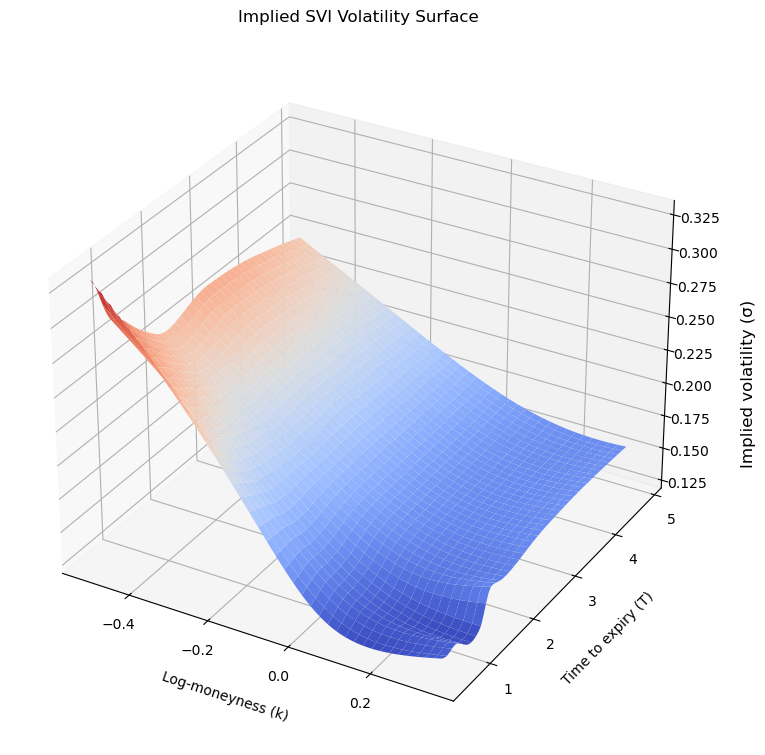

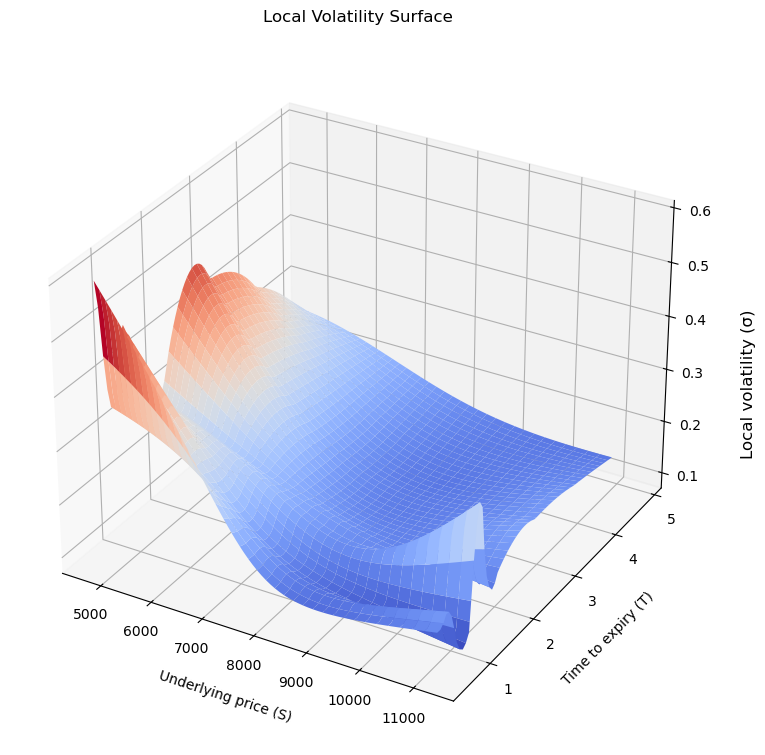

In [25]:
svi_params_df = pd.read_csv(f"MarketData/{eq_underlying}_SVI_{as_of_date.strftime('%d%m%Y')}.csv")
print(f"{eq_underlying} calibrated SVI parameters :")
print(svi_params_df)
print()
# SVI Parameters Extraction
expiries = list(svi_params_df["Expiry"])
svi_expiries = []
i = 0
while i < len(expiries):
    exp = expiries[i]
    for listed_exp in listed_expiries:
        if abs(exp - listed_exp) < 1e-6:
            svi_expiries.append(round(listed_exp, 12))
            break
    i += 1
a, b, rho, m, sigma = dict(), dict(), dict(), dict(), dict()
for i in range(len(svi_expiries)):
    a[svi_expiries[i]] = svi_params_df.iloc[i][1]
    b[svi_expiries[i]] = svi_params_df.iloc[i][2]
    rho[svi_expiries[i]] = svi_params_df.iloc[i][3]
    m[svi_expiries[i]] = svi_params_df.iloc[i][4]
    sigma[svi_expiries[i]] = svi_params_df.iloc[i][5]
# Implied Total Variance : SVI
svi_model = SVIModel(a, b, rho, m, sigma)
svi_model.plot_svi_surface()
# The Implied Forward Curve
forward_curve = ForwardCurve(S0, zc_rate, implied_repos_and_divs)
# The stripped Local Volatility
lv_model = LocalVolatilitySurface(forward_curve, svi_model)
lv_model.plot_lv_surface()

Finally, We proceed to reprice the market vanilla options under the PDE Local Volatility pricer and assess the accuracy of our calibration.
<br>We begin by filtering the market data to extract the prices of out-of-the-money call and put options:

In [26]:
def collect_otm_options():
    """
    Filters the listed options and collects the OTM ones.
    """
    otm_options = dict()
    for exp in listed_expiries:
        strikes_exp = market_strikes[exp]
        calls_exp = call_prices[exp]
        puts_exp = put_prices[exp]
        forward_exp = implied_forwards[exp]
        otm_options_exp = []
        for i in range(len(strikes_exp)):
            otm_options_exp.append(puts_exp[i] if strikes_exp[i] <= forward_exp else calls_exp[i])
        otm_options[exp] = otm_options_exp
    return otm_options

market_prices = collect_otm_options()

Then, we compare the market option prices with those generated by the fitted Local Volatility model:

In [27]:
# LV PDE Pricer
lv_pde_pricer = LocalVolatilityPDEPricer(zc_rate, forward_curve, lv_model, nx=301, dt=0.005)
T_max = max(svi_expiries)
# Precompute time/spot grids and the local-vol grid up to T_max, inserting all expiries to enable reuse and speed up pricing
print(f"Preparing PDE grid up to T_max = {T_max:.4f} ...")
lv_pde_pricer.prepare_grid(T_max, expiries=svi_expiries, apply_smoothness=True)
print("PDE grid prepared.")
# LV calibration quality check
all_rel_err = []
edges  = [0.00, 0.01, 0.02, 0.03, 0.05, np.inf]
labels = ["0–1%", "1–2%", "2–3%", "3–5%", ">5%"]
for exp in svi_expiries:
    strikes = np.array(market_strikes[exp], dtype=float)
    mkt = np.array(market_prices[exp], dtype=float)
    F0T = float(forward_curve.calc_forward(exp))
    isCall = strikes > F0T
    pde_prices = np.zeros_like(strikes, dtype=float)
    for i, (K, c) in enumerate(zip(strikes, isCall)):
        # vanilla_price will reuse the cached grid since self.T >= T
        pde_prices[i] = lv_pde_pricer.vanilla_price(exp, float(K), bool(c))
    # exp calibration stats
    rel_err = np.abs(pde_prices / mkt - 1.0)
    all_rel_err.append(rel_err)
    print(f"\n--- Expiry T = {exp:.6f}  (#{len(strikes)} calibration instruments) ---")
    print("---------------------------------------------------------------")
    print(" idx      K   type       MKT          PDE        relative error")
    print("---------------------------------------------------------------")
    for i, (K, isCall, mkt_price, pde_price, err) in enumerate(zip(strikes, isCall, mkt, pde_prices, rel_err)):
        type = "C" if isCall else "P"
        print(f"{i:4d}  {K:8.2f}   {type}   {mkt_price:10.6f}  {pde_price:10.6f}    {100*err:8.3f}%")
    print("---------------------------------------------------------------")
    x = np.asarray(rel_err, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    counts, _ = np.histogram(x, bins=edges)
    print("+---------+-------+--------+")
    print("| Bucket  | Count |   %    |")
    print("+---------+-------+--------+")
    for lab, c in zip(labels, counts):
        pct = (100.0 * c / n) if n else 0.0
        print(f"| {lab:<7} | {c:>5} | {pct:>6.2f} |")
    print("+---------+-------+--------+")
    print(f"Avg. relative error : {100*np.mean(rel_err):.4f}%\n")
    print("===============================================================================")
# Overall stats
all_rel_err = np.concatenate(all_rel_err) if len(all_rel_err) else np.array([])
print(f"\n--- OVERALL (#{len(all_rel_err)} calibration instruments) : ---")
x = np.asarray(all_rel_err, dtype=float)
x = x[np.isfinite(x)]
n = x.size
counts, _ = np.histogram(x, bins=edges)
print("+---------+-------+--------+")
print("| Bucket  | Count |   %    |")
print("+---------+-------+--------+")
for lab, c in zip(labels, counts):
    pct = (100.0 * c / n) if n else 0.0
    print(f"| {lab:<7} | {c:>5} | {pct:>6.2f} |")
print("+---------+-------+--------+")
print(f"Avg. relative error : {100*np.mean(all_rel_err):.4f}%\n")
print("===============================================================================")


Preparing PDE grid up to T_max = 4.8575 ...
PDE grid prepared.

--- Expiry T = 0.024658  (#11 calibration instruments) ---
---------------------------------------------------------------
 idx      K   type       MKT          PDE        relative error
---------------------------------------------------------------
   0   7925.00   P    27.920000   28.132768       0.762%
   1   7950.00   P    33.590000   33.711369       0.361%
   2   7975.00   P    40.180000   40.479988       0.747%
   3   8000.00   P    47.820000   47.861929       0.088%
   4   8025.00   P    57.170000   57.784436       1.075%
   5   8050.00   C    66.880000   67.472963       0.887%
   6   8075.00   C    54.260000   54.798572       0.993%
   7   8100.00   C    43.410000   43.997957       1.354%
   8   8125.00   C    34.190000   34.257521       0.197%
   9   8150.00   C    26.350000   26.898100       2.080%
  10   8200.00   C    14.920000   15.221589       2.021%
----------------------------------------------------------